## VFS Week 8 Coding Workshop: Trim condition of a rotorcraft using BEMT
Like we mentioned in our lecture last Friday, [(link here to slides)](https://docs.google.com/presentation/d/155mdgfq18Js5Xh4SnBKFxfFHMXQeCplvDu2u_5X6qls/edit?usp=sharing) we can use BEMT to analyze rotor performance for a given (or required) $C_T$. What if we wanted to determine, given a sample selection of twist rates, which one had the best performance? Here's a recap of those equations we showcased last week, along with some we'll need to flesh out our analysis: 

Inflow Equation for Hover (Including Prandtl's Tip Loss):
$$\lambda = \left( \frac{\sigma  C_{L_\alpha}}{16  F} \right)  \left( \sqrt{1 + \left( \frac{32  F}{\sigma  C_{L_\alpha}} \right)  \theta  r} - 1 \right)$$

Geometric Pitch Angle:
$$\theta = \theta_0 + \theta_{tw} \cdot r$$

Prandtl's Tip Loss:
$$F = \left( \frac{2}{\pi} \right) \cos^{-1}{e^{-f}}$$
where f:
$$f = \frac{N_b}{2} \left( \frac{1 - r}{r \phi} \right)$$

Sectional Thrust:
$$\Delta C_T = \frac{\sigma C_{L_\alpha}}{2} \left( \theta r^2 - \lambda r \right) \Delta r$$

(Note: the $\Delta r$ is the discretized version of dr, from the original equation.)

Sectional Coefficient of Lift:
$$\Delta C_L = C_{L_\alpha} \left( \theta - \phi \right)$$

Recall $\phi = \frac{\lambda}{r}$.

Finally,
$$\theta_0^{(j+1)} = \theta_0^{(j)} + \left[ \frac{6(C_{Treq} - C_T^{(j)})}{\sigma C_{L_\alpha}} + \frac{3\sqrt{2}}{4} \left( \sqrt{C_{Treq}} - \sqrt{C_T^{(j)}} \right) \right]$$
gives us the collective (root pitch angle), with 
$$\frac{6 C_{Treq}}{\sigma C_{L_\alpha}} - \frac{3}{4} \theta_{tw} + \frac{3}{4} \sqrt{2 C_{Treq}}$$
being a somewhat good rough approximation.

Note that the equations for $\lambda$ and $\theta_0$ are implicit, which means they have to be solved for iteratively. As $\Delta C_T$ and $\Delta C_L$ depend on these values, they'll have to be solved iteratively also. This calls for many nested loops!

Personally, I use while loops in python for my iterations (it makes the most sense to me). A way to think about an iteration of this manner is: calculating each variable you need, moving down the line, until you have values for each. Then, compare the result of the last value you calculated with its initial value (or, its value from the last loop instance, if this isn't the first loop instance). If the difference between the two is greater than some predefined small number (depends on the case, but here we will use 5e-5), then iterate again. The goal, or the exit condition of the loop, is when the difference of the current and previous values is extremely small, such that the values have "converged" on a single value. First, lets define all the variables we need. I'm using this example from the Leishman textbook: 
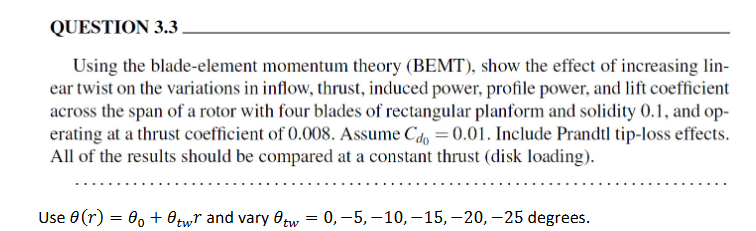

Lets look at the code:

In [1]:
import numpy as np
import matplotlib.pyplot as plt

#Initial Values
sigma = 0.1
C_La = 2 * np.pi
C_Treq = 0.008
C_d0 = 0.01 #we're assuming a constant drag polar, in this case
N_b = 4 #number of blades
N_ds = 51 #number of discretized sections
r = np.linspace(1/(2*N_ds), 1 - 1/(2*N_ds), N_ds) #making our nondimension blade position matrix
delta_r = 1 / N_ds #this is the length of each discretized section

Now we can insert our equations. I'll insert them as functions, to make our iteration loop a little cleaner. 

In [2]:
def theta(t_0, t_tw, r): #we'll come back to this t_tw
    theta = t_0 + t_tw * r
    return theta

def inflow(sigma, C_La, F, theta, r): #I would use lambda as my variable here, but its a reserved term in python
    inflow = ((sigma * C_La) / (16 * F)) * (np.sqrt(1 + ((32 * F) / (sigma * C_La)) * theta * r) - 1)
    return inflow

def prandtls(f):
    F = 2 / np.pi * np.arccos(np.e ** (-f))
    return F

def sprandtls(N_b, r, inflow):
    f = (N_b/2) * ((1 - r)/inflow)
    return f

def secthrust(sigma, C_La, theta, r, inflow, delta_r):
    dC_T = (sigma * C_La)/2 * (theta * r ** 2 - inflow * r) * delta_r
    return dC_T

def seclift(C_La, theta, inflow, r):
    dC_L = C_La * (theta - (inflow/r))
    return dC_L

def collective(theta_0i, C_Treq, C_Ti, sigma, C_La):
    theta_0 = theta_0i + (6 * (C_Treq - C_Ti))/(sigma * C_La) + (3 * np.sqrt(2))/4 * (np.sqrt(C_Treq) - np.sqrt(C_Ti))
    return theta_0

def colini(C_Treq, sigma, C_La, t_tw):
    colini = (6 * C_Treq)/(sigma * C_La) - 3/4 * t_tw + 3/4 * np.sqrt(2 *C_Treq)
    return colini

def profpow(sigma, C_d0, r, delta_r):
    C_P0 = (sigma / 2) * C_d0 * (r ** 3) * delta_r
    return C_P0

Now that that's done, we can use those functions to calculate our needed values by simply inputing input variables and assigning the output to a variable. For example ```dC_L = seclift(2*np.pi, 20, 0.4, 0.5)``` would give me the sectional lift at a value of $2 \pi$ for $C_{L_{\alpha}}$, 20 deg for geometric pitch @ a given radial location of 0.5 and an inflow of 0.4. Here's our loop function: (Note: as Prandtl's Factor is an input for inflow, we have to iterate for F each time we attempt to find inflow. This requires a nested loop.)

In [3]:
def collectiveiteration(t_tw): #notice how this whole function calculates everything based on a given twist angle
    #iteration loop:
    #initialization of loop:
    Fold = 1
    t_0old = colini(C_Treq, sigma, C_La, t_tw)
    res =  1 # this is to make sure the loop doesnt exit after first iteration
    while res >= 1e-5:
        #here's that nested loop
        while res >= 1e-5:
            inflow_val = inflow(sigma, C_La, Fold, theta(t_0old, t_tw, r), r)
            f_val = sprandtls(N_b, r, inflow_val)
            F = prandtls(f_val)
            res = abs(F - Fold).max()
            Fold = F
        inflow_val = inflow(sigma, C_La, F, theta(t_0old, t_tw, r), r)
        Cl_val = seclift(C_La, theta(t_0old, t_tw, r), inflow_val, r)
        dCt_val = secthrust(sigma, C_La, theta(t_0old, t_tw, r), r, inflow_val, delta_r)
        Ct_val = np.sum(dCt_val)
        Cpi_val = dCt_val * inflow_val
        Cp0_val = profpow(sigma, C_d0, r, delta_r)
        t_0val = collective(t_0old, C_Treq, Ct_val, sigma, C_La)
        res = abs(t_0val - t_0old)
        t_0old = t_0val
    return inflow_val, Cl_val, dCt_val, Cpi_val, Cp0_val
    

Going back to the first comment in the cell above, we want to compare twist angles of different rotors. So, having one function that calculates everything based one parameter (our analysis parameter) is helpful for iterating that function a bunch of times for different twist rates. All of the output parameters for the ```collectiveiteration(t_tw)``` function are 1x51 arrays though, so to be able to think about our results we'll need to graph them. This can be done using the matplotlib library. Notice how, in the code below, we are using a *for* loop instead of a *while* loop; this type of loop will iterate across a certain variable given an array input, with the contents inside using the 0th, 1st, 2nd value of the array as the scalar variable value in each iteration. This helps us create curves of all our data for each value of twist we are interested in. Matplotlib notation is a little hard to parse if you're not familiar with it, but a helpful rule of thumb is that ```plt.figure()``` creates a graph, while ```plt.plot()``` plots a curve on that graph. Everything below a ```plt.figure()``` command is in reference to that graph, until a new ```plt.figure``` command is used. The rest is just graph customization :)

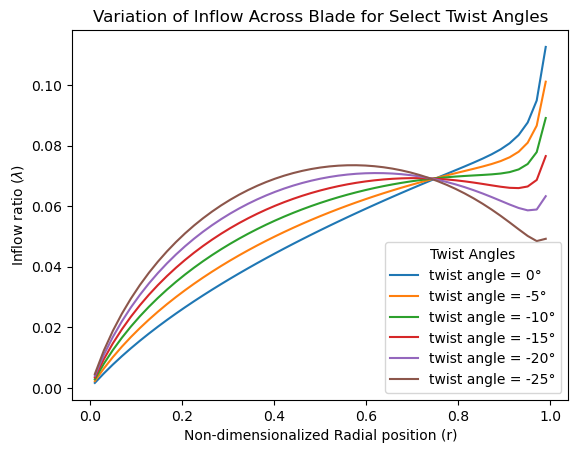

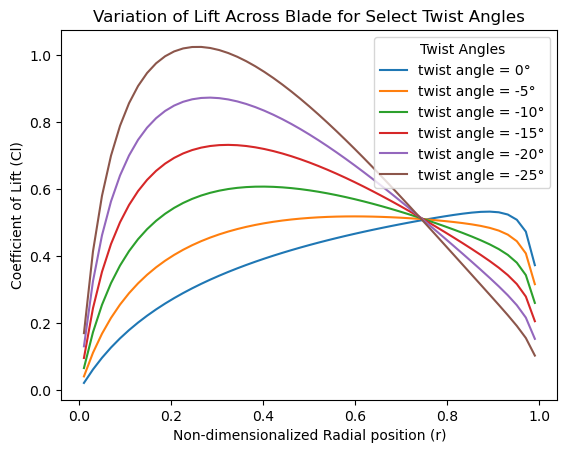

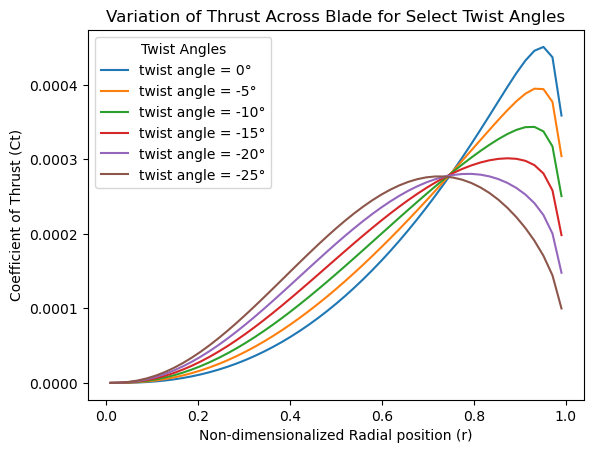

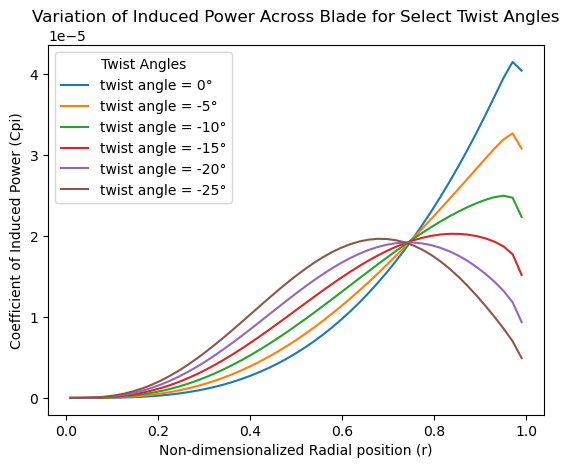

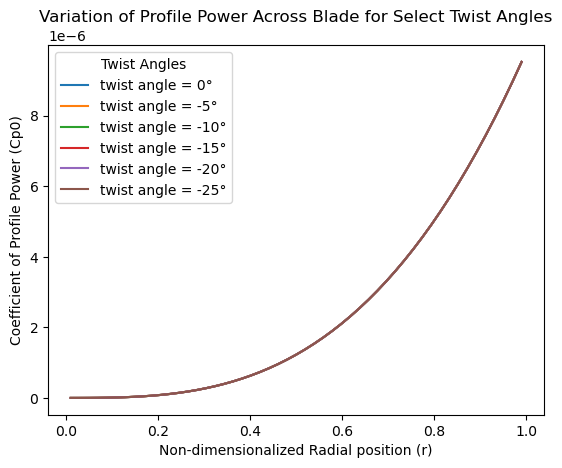

In [4]:
for t_tw in [0, -5, -10, -15, -20, -25]:
    inflow_ratio, lift, thrust, inducedp, profp = collectiveiteration(np.deg2rad(t_tw))
    plt.figure(1)
    plt.plot(r, inflow_ratio, label=f"twist angle = {t_tw}°")
    
    plt.figure(2)
    plt.plot(r, lift, label=f"twist angle = {t_tw}°")

    plt.figure(3)
    plt.plot(r, thrust, label=f"twist angle = {t_tw}°")

    plt.figure(4)
    plt.plot(r, inducedp, label=f"twist angle = {t_tw}°")

    plt.figure(5)
    plt.plot(r, profp, label=f"twist angle = {t_tw}°")

plt.figure(1)
plt.xlabel("Non-dimensionalized Radial position (r)")
plt.ylabel("Inflow ratio ($\\lambda$)")
plt.title("Variation of Inflow Across Blade for Select Twist Angles")
plt.legend(title="Twist Angles")

plt.figure(2)
plt.xlabel("Non-dimensionalized Radial position (r)")
plt.ylabel("Coefficient of Lift (Cl)")
plt.title("Variation of Lift Across Blade for Select Twist Angles")
plt.legend(title="Twist Angles")

plt.figure(3)
plt.xlabel("Non-dimensionalized Radial position (r)")
plt.ylabel("Coefficient of Thrust (Ct)")
plt.title("Variation of Thrust Across Blade for Select Twist Angles")
plt.legend(title="Twist Angles")

plt.figure(4)
plt.xlabel("Non-dimensionalized Radial position (r)")
plt.ylabel("Coefficient of Induced Power (Cpi)")
plt.title("Variation of Induced Power Across Blade for Select Twist Angles")
plt.legend(title="Twist Angles")

plt.figure(5)
plt.xlabel("Non-dimensionalized Radial position (r)")
plt.ylabel("Coefficient of Profile Power (Cp0)")
plt.title("Variation of Profile Power Across Blade for Select Twist Angles")
plt.legend(title="Twist Angles")

plt.show()